In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, balanced_accuracy_score, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.impute import SimpleImputer
from collections import Counter
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, GRU, Bidirectional, BatchNormalization
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import joblib

# Function to load and preprocess patient data
def load_and_preprocess_patient(file_path, common_columns):
    patient_data = pd.read_csv(file_path, sep='|')

    # Check if necessary columns exist
    missing_columns = set(common_columns) - set(patient_data.columns)
    for col in missing_columns:
        print(f"Warning: Column '{col}' not found in {file_path}. Skipping this column.")

    # Extract time-series data (excluding static features)
    time_series_data = patient_data.drop(columns=common_columns)

    # Extract static features
    static_features = patient_data[common_columns].iloc[0].to_numpy()

    # Extract sepsis label (or default to NaN if not present)
    sepsis_label = patient_data.get('SepsisLabel', np.nan).iloc[0]

    return time_series_data, static_features, sepsis_label

# Function to load all patient files
def load_patients(data_path, num_files=20335):
    common_columns = ['Age', 'Gender', 'Unit1', 'Unit2', 'HospAdmTime', 'ICULOS']

    all_time_series_data = []
    all_static_features = []
    all_sepsis_labels = []
    patient_ids = []

    for i, file_name in enumerate(os.listdir(data_path)):
        if i >= num_files:
            break

        file_path = os.path.join(data_path, file_name)

        # Load and preprocess patient data
        time_series_data, static_features, sepsis_label = load_and_preprocess_patient(file_path, common_columns)

        # If time-series data is empty, skip this patient
        if time_series_data.empty:
            continue

        # Pad or truncate the time-series data to a fixed length
        time_series_data = process_patient_time_series(time_series_data)

        all_time_series_data.append(time_series_data)
        all_static_features.append(static_features)
        all_sepsis_labels.append(sepsis_label)
        patient_ids.append(file_name)

    # Convert lists to numpy arrays
    X = np.array(all_time_series_data)
    static_features = np.array(all_static_features)
    y = np.array(all_sepsis_labels)

    return X, static_features, y, patient_ids

# Function to process the time-series data to ensure a fixed length
def process_patient_time_series(time_series_data, TIME_SERIES_LENGTH=50):
    num_timepoints = time_series_data.shape[0]

    if num_timepoints < TIME_SERIES_LENGTH:
        # Pad the time-series data
        padding = np.nan * np.ones((TIME_SERIES_LENGTH - num_timepoints, time_series_data.shape[1]))
        time_series_data = pd.DataFrame(np.vstack([time_series_data.values, padding]), columns=time_series_data.columns)
    elif num_timepoints > TIME_SERIES_LENGTH:
        # Truncate to the desired length
        time_series_data = time_series_data.iloc[:TIME_SERIES_LENGTH, :]

    return time_series_data


def preprocess_data(X, y, test_size=0.2, val_size=0.2, random_state=42):
    # Flatten the time-series data for input into the model
    X_flat = X.reshape(X.shape[0], -1)

    # Impute missing values in the flattened data
    imputer = SimpleImputer(strategy='mean')
    X_flat = imputer.fit_transform(X_flat)

    # Split into training and test sets (80% training, 20% testing)
    X_train, X_test, y_train, y_test = train_test_split(X_flat, y, test_size=test_size, random_state=random_state)

    # Further split the training data into training and validation sets (60% train, 20% validation)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_size, random_state=random_state)

    # Standardize the data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)

    joblib.dump(scaler, 'scaler.pkl')

    # Ensure no NaN or inf values are present after scaling
    X_train = np.nan_to_num(X_train, nan=0.0, posinf=1.0, neginf=-1.0)
    X_val = np.nan_to_num(X_val, nan=0.0, posinf=1.0, neginf=-1.0)
    X_test = np.nan_to_num(X_test, nan=0.0, posinf=1.0, neginf=-1.0)

    return X_train, X_val, X_test, y_train, y_val, y_test


def balance_data(X_train, y_train):
    # Debugging: Check initial class distribution
    class_distribution = Counter(y_train)
    print(f"Class distribution before SMOTE: {class_distribution}")

    # Debugging: Check for NaNs
    print("Any NaNs in X_train before SMOTE:", np.isnan(X_train).any())
    print("Shape of X_train before SMOTE:", X_train.shape)

    try:
        smote = SMOTE(sampling_strategy='auto', random_state=42, k_neighbors=5)
        X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
    except ValueError as e:
        print(f"Error during SMOTE: {e}")
        return X_train, y_train

    # Debugging: Check final class distribution
    print(f"Class distribution after SMOTE: {Counter(y_train_resampled)}")

    return X_train_resampled, y_train_resampled

# Preprocess data for LSTM
def preprocess_data_for_lstm(X_train, X_val, X_test, time_steps=13):
    # Get the number of features in the flattened data
    num_features = X_train.shape[1]

    print(f"Original number of features: {num_features}")

    # Manually adjust number of features to be divisible by time_steps
    if num_features % time_steps != 0:
        new_num_features = num_features + (time_steps - num_features % time_steps)
        print(f"Adjusting number of features from {num_features} to {new_num_features} by adding padding.")

        X_train = np.pad(X_train, ((0, 0), (0, new_num_features - num_features)), 'constant', constant_values=np.nan)
        X_val = np.pad(X_val, ((0, 0), (0, new_num_features - num_features)), 'constant', constant_values=np.nan)
        X_test = np.pad(X_test, ((0, 0), (0, new_num_features - num_features)), 'constant', constant_values=np.nan)

        num_features = new_num_features

    # Calculate the number of features per time step
    features_per_time_step = num_features // time_steps
    print(f"Features per time step: {features_per_time_step}")

    # Reshape data for LSTM input (samples, time_steps, features_per_time_step)
    X_train_lstm = X_train.reshape((X_train.shape[0], time_steps, features_per_time_step))
    X_val_lstm = X_val.reshape((X_val.shape[0], time_steps, features_per_time_step))
    X_test_lstm = X_test.reshape((X_test.shape[0], time_steps, features_per_time_step))

    return X_train_lstm, X_val_lstm, X_test_lstm

# Train and evaluate LSTM model with class weights
def train_and_evaluate_lstm_v2(X_train_lstm, X_val_lstm, X_test_lstm, y_train, y_val, y_test, pts):
    # Calculate class weights
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train),
        y=y_train
    )
    class_weight_dict = dict(enumerate(class_weights))
    print(f"Original Class Weights: {class_weight_dict}")

    # Optionally, adjust the weight for the minority class (sepsis) manually
    class_weight_dict[1] *= 20  # Increase the weight of the sepsis class (class 1)
    print(f"Adjusted Class Weights: {class_weight_dict}")

    # Build a more complex LSTM model with Bidirectional LSTM, GRU, and BatchNormalization
    model = Sequential()

    # First Bidirectional LSTM layer
    model.add(Bidirectional(LSTM(128, activation='relu', return_sequences=True), input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
    model.add(Dropout(0.3))
    model.add(BatchNormalization())

    # Second LSTM layer
    model.add(LSTM(64, activation='relu', return_sequences=True))
    model.add(Dropout(0.3))
    model.add(BatchNormalization())

    # Third GRU layer (experimenting with GRU instead of LSTM)
    model.add(GRU(32, activation='relu', return_sequences=False))
    model.add(Dropout(0.3))
    model.add(BatchNormalization())

    # Output Layer
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    # model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, clipvalue=1.0), loss='binary_crossentropy', metrics=['accuracy'])

    # Early stopping to prevent overfitting
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Train the model with class weights and store history for plotting
    history = model.fit(
        X_train_lstm, y_train,
        epochs=30,
        batch_size=64,
        validation_data=(X_val_lstm, y_val),
        class_weight=class_weight_dict,  # Pass class weights to the model
        callbacks=[early_stopping]  # Use early stopping to prevent overfitting
    )

    # Plot training & validation loss
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training & Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Predict probabilities on the test set
    y_pred_prob = model.predict(X_test_lstm)

    # Check for NaN values in y_pred_prob and handle them
    if np.any(np.isnan(y_pred_prob)):
        print("Warning: y_pred_prob contains NaN values. Handling NaNs...")
        y_pred_prob = np.nan_to_num(y_pred_prob, nan=0.0)  # Replace NaNs with 0.0

    # Convert predicted probabilities to binary labels (0 or 1)
    y_pred = (y_pred_prob > 0.3).astype("int32")

    # Print classification report and confusion matrix
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    print(f"Balanced Accuracy Score: {balanced_accuracy_score(y_test, y_pred)}")

    # Compute ROC AUC score
    try:
        roc_auc = roc_auc_score(y_test, y_pred_prob)
        print(f"ROC AUC Score: {roc_auc}")
    except ValueError:
        print("Error in ROC AUC calculation. Check if y_test and y_pred_prob contain NaNs or have mismatched shapes.")

    # Plot Confusion Matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["Non-Sepsis", "Sepsis"])
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

    # Precision Recall curve
    precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
    plt.plot(recall, precision, color='blue', lw=2)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.show()

    # Plot ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

        # Trace predictions back to patient IDs
    for i in range(len(y_pred)):
        patient_id = pts[i]
        print(f"Patient ID: {patient_id}")


    return model



In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"xinqilee96","key":"cd817538d5350a19209dfb8519956330"}'}

In [ ]:
!pip install -q kaggle

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("salikhussaini49/prediction-of-sepsis")

print("Path to dataset files:", path)

100%|██████████| 74.7M/74.7M [00:04<00:00, 17.2MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/salikhussaini49/prediction-of-sepsis/versions/2


In [ ]:
!kaggle datasets download salikhussaini49/prediction-of-sepsis

Dataset URL: https://www.kaggle.com/datasets/salikhussaini49/prediction-of-sepsis
License(s): CC-BY-NC-SA-4.0
100% 74.7M/74.7M [00:04<00:00, 23.9MB/s]
100% 74.7M/74.7M [00:04<00:00, 18.0MB/s]


In [ ]:
!ls

kaggle.json  prediction-of-sepsis.zip  sample_data


In [ ]:
!unzip prediction-of-sepsis.zip

Streaming output truncated to the last 5000 lines.
  inflating: training_setB/training_setB/p115003.psv  
  inflating: training_setB/training_setB/p115004.psv  
  inflating: training_setB/training_setB/p115005.psv  
  inflating: training_setB/training_setB/p115006.psv  
  inflating: training_setB/training_setB/p115007.psv  
  inflating: training_setB/training_setB/p115008.psv  
  inflating: training_setB/training_setB/p115009.psv  
  inflating: training_setB/training_setB/p115010.psv  
  inflating: training_setB/training_setB/p115011.psv  
  inflating: training_setB/training_setB/p115012.psv  
  inflating: training_setB/training_setB/p115013.psv  
  inflating: training_setB/training_setB/p115014.psv  
  inflating: training_setB/training_setB/p115015.psv  
  inflating: training_setB/training_setB/p115016.psv  
  inflating: training_setB/training_setB/p115017.psv  
  inflating: training_setB/training_setB/p115018.psv  
  inflating: training_setB/training_setB/p115019.psv  
  inflating: t

In [ ]:
# Main function to load, preprocess, and train the model
data_path = r'/content/training_setA/training'
X1, static_features1, y1, p = load_patients(data_path)

# Preprocess data for machine learning
X_train1, X_val1, X_test1, y_train1, y_val1, y_test1 = preprocess_data(X1, y1)





/usr/local/lib/python3.10/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: [   7   42   77  112  147  182  217  252  287  322  357  392  427  462
  497  532  567  602  637  672  707  742  777  812  847  882  917  952
  987 1022 1057 1092 1127 1162 1197 1232 1267 1302 1337 1372 1407 1442
 1477 1512 1547 1567 1582 1617 1652 1687 1722]. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


In [ ]:
# Balance the data using SMOTE
X_train_resampled1, y_train_resampled1 = balance_data(X_train1, y_train1)



Class distribution before SMOTE: Counter({0: 12879, 1: 135})
Any NaNs in X_train before SMOTE: False
Shape of X_train before SMOTE: (13014, 1699)
Class distribution after SMOTE: Counter({0: 12879, 1: 12879})


In [ ]:
np.save("X_train_resampled.npy", X_train_resampled1)
np.save("y_train_resampled.npy", y_train_resampled1)


In [ ]:
# Preprocess data for LSTM
X_train_lstm1, X_val_lstm1, X_test_lstm1 = preprocess_data_for_lstm(X_train_resampled1, X_val1, X_test1)



Original number of features: 1699
Adjusting number of features from 1699 to 1703 by adding padding.
Features per time step: 131


In [ ]:
X_train_lstm1 = np.nan_to_num(X_train_lstm1, nan=0.0, posinf=1.0, neginf=-1.0)
X_val_lstm1 = np.nan_to_num(X_val_lstm1, nan=0.0, posinf=1.0, neginf=-1.0)
X_test_lstm1 = np.nan_to_num(X_test_lstm1, nan=0.0, posinf=1.0, neginf=-1.0)


Original Class Weights: {0: 1.0, 1: 1.0}
Adjusted Class Weights: {0: 1.0, 1: 20.0}


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
403/403 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.8741 - loss: 2.6418 - val_accuracy: 0.9926 - val_loss: 0.0901
Epoch 2/30
403/403 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9974 - loss: 0.2938 - val_accuracy: 0.9945 - val_loss: 0.0375
Epoch 3/30
403/403 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9979 - loss: 0.1504 - val_accuracy: 0.9966 - val_loss: 0.0230
Epoch 4/30
403/403 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9986 - loss: 0.0854 - val_accuracy: 0.9972 - val_loss: 0.0173
Epoch 5/30
403/403 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9994 - loss: 0.0678 - val_accuracy: 0.9985 - val_loss: 0.0113
Epoch 6/30
403/403 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9995 - loss: 0.0442 - val_accuracy: 0.9982 - val_loss: 0.0105
Epoch 7/30
403/403 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9995 - loss: 0.0325 - val_accuracy: 0.9985 - val_loss: 0.0081
Epoch 8/30
403/403 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9997 - loss: 0.0230 - val_acc

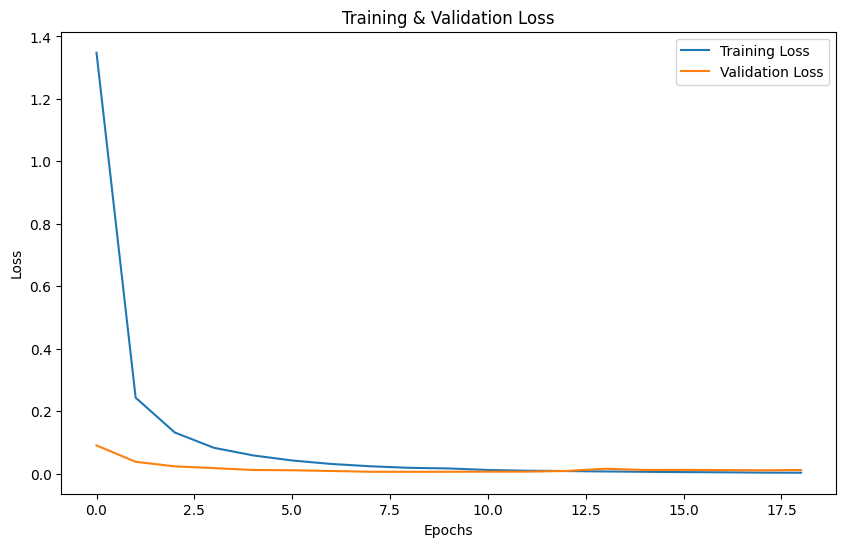

128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4028
           1       0.95      0.97      0.96        39

    accuracy                           1.00      4067
   macro avg       0.97      0.99      0.98      4067
weighted avg       1.00      1.00      1.00      4067

Balanced Accuracy Score: 0.9869312250146411
ROC AUC Score: 0.9999490744277238


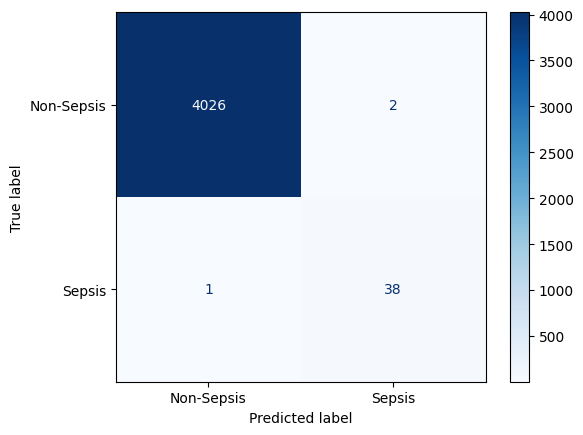

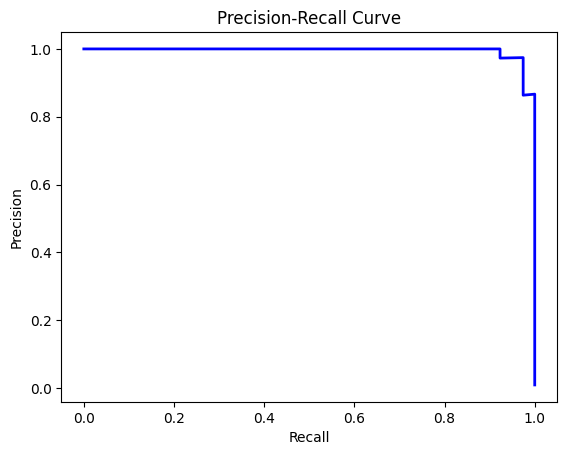

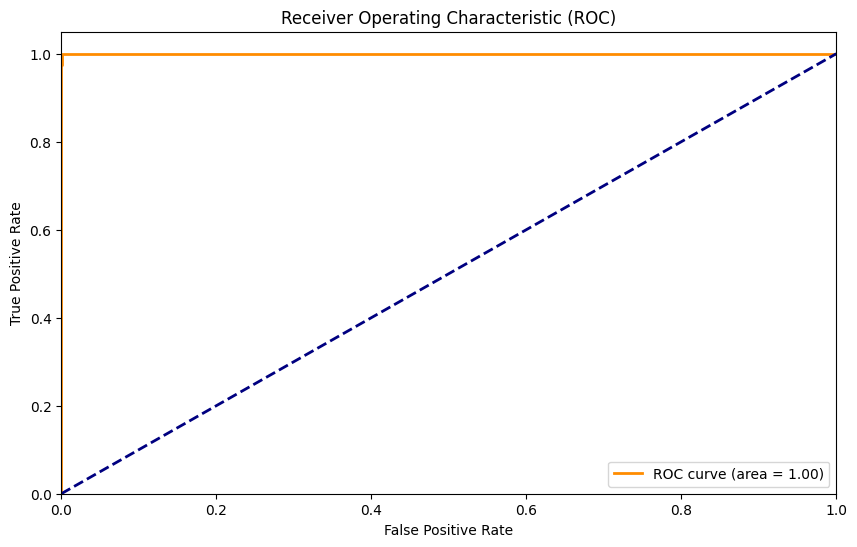

Patient ID: p008363.psv
Patient ID: p000680.psv
Patient ID: p019273.psv
Patient ID: p002279.psv
Patient ID: p001198.psv
Patient ID: p019195.psv
Patient ID: p014634.psv
Patient ID: p008751.psv
Patient ID: p014367.psv
Patient ID: p012638.psv
Patient ID: p006843.psv
Patient ID: p000567.psv
Patient ID: p004565.psv
Patient ID: p015056.psv
Patient ID: p000578.psv
Patient ID: p016585.psv
Patient ID: p006118.psv
Patient ID: p005234.psv
Patient ID: p002652.psv
Patient ID: p005096.psv
Patient ID: p014259.psv
Patient ID: p000988.psv
Patient ID: p017687.psv
Patient ID: p003350.psv
Patient ID: p006610.psv
Patient ID: p015516.psv
Patient ID: p008872.psv
Patient ID: p011152.psv
Patient ID: p015076.psv
Patient ID: p014351.psv
Patient ID: p016280.psv
Patient ID: p002692.psv
Patient ID: p008325.psv
Patient ID: p013185.psv
Patient ID: p010825.psv
Patient ID: p005884.psv
Patient ID: p014366.psv
Patient ID: p019877.psv
Patient ID: p016722.psv
Patient ID: p010305.psv
Patient ID: p018459.psv
Patient ID: p005

In [ ]:
# Train and evaluate the LSTM model
model = train_and_evaluate_lstm_v2(X_train_lstm1, X_val_lstm1, X_test_lstm1, y_train_resampled1, y_val1, y_test1, p)

In [ ]:
print("Any NaNs in X_train_lstm:", np.isnan(X_train_lstm1).any())
print("Any NaNs in X_val_lstm:", np.isnan(X_val_lstm1).any())
print("Any NaNs in X_test_lstm:", np.isnan(X_test_lstm1).any())
print("Any infinities in X_train_lstm:", np.isinf(X_train_lstm1).any())


Any NaNs in X_train_lstm: False
Any NaNs in X_val_lstm: False
Any NaNs in X_test_lstm: False
Any infinities in X_train_lstm: False


## CIndy Test

In [ ]:
def get_patient_prediction(patient_id, X_test_lstm, patient_ids_test, model):
    # Find the index of the patient_id in the list of patient_ids_test
    patient_index = patient_ids_test.index(patient_id)

    # Get the corresponding input data for this patient from X_test_lstm
    patient_data = X_test_lstm[patient_index:patient_index+1]

    # Predict using the trained model
    y_pred_prob = model.predict(patient_data)

    # Convert predicted probabilities to binary labels (0 or 1)
    y_pred = (y_pred_prob > 0.3).astype("int32")

    # Trace the prediction to the patient ID
    predicted_label = "Sepsis" if y_pred == 1 else "Non-Sepsis"

    return predicted_label, y_pred_prob[0][0], y_pred[0][0]


In [ ]:
# Example usage
patient_id = 'p016166.psv'  # Specify the patient ID
# Assuming the test data is already preprocessed and `X_test_lstm` is ready
# Also, `patient_ids_test` contains the IDs of all patients in the test set

# Get the prediction and probability for the specific patient
predicted_label, predicted_prob, predicted_class = get_patient_prediction(patient_id, X_test_lstm1, p, model)

# Output the result
print(f"Patient: {patient_id}, Predicted Sepsis: {predicted_label}, Probability: {predicted_prob}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Patient: p016166.psv, Predicted Sepsis: Non-Sepsis, Probability: 0.002827004762366414


In [ ]:
def find_patients_with_sepsis(X_test_lstm, patient_ids_test, model, threshold=0.3):
    # Get the predictions for all test patients
    y_pred_prob = model.predict(X_test_lstm)

    # Find patients with Sepsis (y_pred == 1) based on a threshold
    sepsis_patients = []
    for i, prob in enumerate(y_pred_prob):
        if prob[0] > threshold:  # If the predicted probability of Sepsis is greater than the threshold
            sepsis_patients.append((patient_ids_test[i], prob[0]))

    return sepsis_patients


In [ ]:
sepsis_patients = find_patients_with_sepsis(X_test_lstm1, p, model)

# Output the results
print("Patients predicted to have Sepsis:")
for patient_id, prob in sepsis_patients:
    print(f"Patient: {patient_id}, Predicted Sepsis Probability: {prob}")

128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Patients predicted to have Sepsis:
Patient: p010793.psv, Predicted Sepsis Probability: 0.9995490908622742
Patient: p009128.psv, Predicted Sepsis Probability: 0.7025318741798401
Patient: p018818.psv, Predicted Sepsis Probability: 0.9983958601951599
Patient: p008538.psv, Predicted Sepsis Probability: 0.9994598031044006
Patient: p011087.psv, Predicted Sepsis Probability: 0.9995235204696655
Patient: p017451.psv, Predicted Sepsis Probability: 0.9995266199111938
Patient: p005388.psv, Predicted Sepsis Probability: 0.9993502497673035
Patient: p016072.psv, Predicted Sepsis Probability: 0.9994829893112183
Patient: p000895.psv, Predicted Sepsis Probability: 0.9994675517082214
Patient: p015412.psv, Predicted Sepsis Probability: 0.9992536902427673
Patient: p012079.psv, Predicted Sepsis Probability: 0.9993664622306824
Patient: p018950.psv, Predicted Sepsis Probability: 0.9994656443595886
Patient: p010701.psv, Predicted Sepsis Probability: 0.9985182881355286
P

In [ ]:
import pandas as pd
def create_prompts_for_patient(patient_id, csv_file_path):
    # Read the CSV file
    df = pd.read_csv(csv_file_path)

    # Extract the patient identifier from the patient_id (e.g., p000001.psv -> 1)
    patient_num = int(patient_id.split('p')[1].split('.')[0])  # Extracts the '1' from p000001.psv

    # Filter the rows for the specific patient (where 'identifier' column matches)
    patient_data = df[df['Identifier'] == patient_num]

    # Initialize a list to hold the narrative segments
    narrative_segments = []

    # Loop through the rows and create a narrative for each one
    for _, row in patient_data.iterrows():
        # Extract required fields from the row
        hour = row['Hour']
        hr = row['HR']
        o2sat = row['O2Sat']
        sbp = row['SBP']
        map_value = row['MAP']
        resp = row['Resp']

        # Create a narrative sentence for the row
        segment = (
            f"At hour {hour}, the patient's vitals were as follows: "
            f"Heart Rate (HR) was {hr}, Oxygen Saturation (O2Sat) was {o2sat}, "
            f"Systolic Blood Pressure (SBP) was {sbp}, Mean Arterial Pressure (MAP) was {map_value}, "
            f"and Respiratory Rate (Resp) was {resp}."
        )

        # Append the segment to the list
        narrative_segments.append(segment)

    # Combine all segments into a single paragraph
    narrative_paragraph = (
        f"Patient {patient_num} has the following recorded data. " +
        " ".join(narrative_segments)
    )

    return narrative_paragraph



In [ ]:
csv_file_path = r'/content/df_filled.csv'

In [ ]:
df = pd.read_csv(csv_file_path)

In [ ]:
df.head()

,HR,O2Sat,SBP,MAP,DBP,Resp,Hour,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,Identifier,SepsisLabel
0,81.84705,97.326644,124.141712,78.584889,56.688948,18.549539,0.0,83.0,0.0,0.496571,0.503429,-0.0,1.0,1.0,0
1,97.00000,95.000000,98.000000,75.330000,58.610013,19.000000,1.0,83.0,0.0,0.496571,0.503429,-0.0,2.0,1.0,0
2,89.00000,99.000000,122.000000,86.000000,63.714880,22.000000,2.0,83.0,0.0,0.496571,0.503429,-0.0,3.0,1.0,0
3,90.00000,95.000000,124.707956,78.916186,57.320858,30.000000,3.0,83.0,0.0,0.496571,0.503429,-0.0,4.0,1.0,0
4,103.00000,88.500000,122.000000,91.330000,69.347898,24.500000,4.0,83.0,0.0,0.496571,0.503429,-0.0,5.0,1.0,0


In [ ]:
text = create_prompts_for_patient('p000009.psv', csv_file_path)

In [ ]:
print(text)

Patient 9 has the following recorded data. At hour 0.0, the patient's vitals were as follows: Heart Rate (HR) was 89.54417643117125, Oxygen Saturation (O2Sat) was 97.63967563770176, Systolic Blood Pressure (SBP) was 117.9747444051342, Mean Arterial Pressure (MAP) was 82.85375291345521, and Respiratory Rate (Resp) was 17.95723257999969. At hour 1.0, the patient's vitals were as follows: Heart Rate (HR) was 117.0, Oxygen Saturation (O2Sat) was 99.0, Systolic Blood Pressure (SBP) was 116.0, Mean Arterial Pressure (MAP) was 97.0, and Respiratory Rate (Resp) was 20.0. At hour 2.0, the patient's vitals were as follows: Heart Rate (HR) was 89.59260227620699, Oxygen Saturation (O2Sat) was 97.63046578524822, Systolic Blood Pressure (SBP) was 118.0298044920609, Mean Arterial Pressure (MAP) was 82.86027052816057, and Respiratory Rate (Resp) was 17.990721739645025. At hour 3.0, the patient's vitals were as follows: Heart Rate (HR) was 89.61681519872486, Oxygen Saturation (O2Sat) was 97.62586085902

In [ ]:
import openai
from openai import OpenAI

client = OpenAI(api_key='')
GPT_MODEL = "gpt-4-1106-preview" #"gpt-3.5-turbo-1106"
csv_file_path1 = r'/content/df_filled.csv'
patient_file_name1 = 'p010793.psv'

def generate_recommendation_with_openai(patient_file_name, sepsis_prediction, csv_file_path):
    sepsis_status = "Sepsis Detected" if sepsis_prediction == 1 else "No Sepsis Detected"
    prompt_main = create_prompts_for_patient(patient_file_name, csv_file_path)
    print(prompt_main)
    try:
        response = client.chat.completions.create(
            model=GPT_MODEL,  # Use "gpt-4" or "gpt-3.5-turbo"
            messages=[
                {"role": "system", "content": "You are a medical assistant providing recommendations based on patient data."},
                {"role": "user", "content": prompt_main}
            ],
            max_tokens=3000,  # Adjust for desired output length
            temperature=0.7  # Adjust for creativity
        )
        response_message = response.choices[0].message.content
        #response_message = response['choices'][0]['message']['content']
        return response_message
    except Exception as e:
        return f"Error generating recommendation: {str(e)}"

# LSTM-GPT pipeline
def lstm_gpt_pipeline(patient_file_name, csv_file_path):
    # Step 1: Predict sepsis using the LSTM model
    predicted_label, predicted_prob, predicted_class = get_patient_prediction(patient_file_name, X_test_lstm1, p, model)
    recommendation = generate_recommendation_with_openai(patient_file_name, predicted_class, csv_file_path)

    return {"sepsis_prediction": predicted_class, "recommendation": recommendation}



In [ ]:
# Use the pipeline
result = lstm_gpt_pipeline(patient_file_name1, csv_file_path1)

print("Sepsis Prediction:", result["sepsis_prediction"])
print("Recommendation:", result["recommendation"])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Patient 10793 has the following recorded data. At hour 0.0, the patient's vitals were as follows: Heart Rate (HR) was 82.98353476298577, Oxygen Saturation (O2Sat) was 97.3828597659583, Systolic Blood Pressure (SBP) was 123.55383483058692, Mean Arterial Pressure (MAP) was 79.59140857959898, and Respiratory Rate (Resp) was 18.436012733161355. At hour 1.0, the patient's vitals were as follows: Heart Rate (HR) was 76.0, Oxygen Saturation (O2Sat) was 96.0, Systolic Blood Pressure (SBP) was 141.0, Mean Arterial Pressure (MAP) was 79.0, and Respiratory Rate (Resp) was 17.0. At hour 2.0, the patient's vitals were as follows: Heart Rate (HR) was 76.0, Oxygen Saturation (O2Sat) was 99.0, Systolic Blood Pressure (SBP) was 135.0, Mean Arterial Pressure (MAP) was 73.33, and Respiratory Rate (Resp) was 16.5. At hour 3.0, the patient's vitals were as follows: Heart Rate (HR) was 72.0, Oxygen Saturation (O2Sat) was 96.0, Systolic Blood Pressure (SBP) was 132.0, Me